In [1]:
import pandas as pd
import gzip
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
# LOCAL = 'Avenches'
LOCAL = 'Lausanne'
activity_types = ['work', 'education', 'leisure', 'shop']

In [3]:
def round_to_horizon(t):
    """ Help to round a time to 5m intervals """
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), t)
    
    # Find the number of seconds since midnight
    seconds_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).seconds

    # Round to the closest 5 minutes (300 seconds)
    rounded_seconds = round(seconds_since_midnight / 300) * 300
    rounded_dt = dt.replace(hour=0, minute=0, second=0) + timedelta(seconds=rounded_seconds)

    return rounded_dt.time()

def time_to_horizon_interval(t):
    """ Return time horizon corresponding to a timestamp """
    rounded_time = round_to_horizon(t)
    
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), rounded_time)
    
    # Get total minutes since midnight
    minutes_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0)).seconds // 60

    # Convert total minutes to horizon intervals (5 minute intervals)
    horizon_interval = minutes_since_midnight // 5

    return horizon_interval

def convert_to_time(value):
    """ Check that all time values are correct (hours<24)"""
    try:
        # Try converting the value to datetime and extract the time
        return pd.to_datetime(value).time()
    except:
        # Return a placeholder for out-of-range values
        return 1

In [5]:
activity_file_path = 'Data/1_Original/vaud_activities.csv.gz'
population_file_path = 'Data/1_Original/vaud_population.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

activity_vaud = read_gzipped_csv(activity_file_path)
population_vaud = read_gzipped_csv(population_file_path)[['id', 'age', 'home_x', 'home_y', 'local', 'employed', 'sex']]

In [18]:
population_local = population_vaud[population_vaud['local'] == LOCAL] 
population_local_ids = population_local['id'].unique()
print(len(population_local_ids))
activity_local = activity_vaud[activity_vaud['id'].isin(population_local_ids)]
activity_local_filt = activity_local[~activity_local['type'].isin(['other', 'pt interaction', 'home'])] 

139392


## Work facilities distribution

In [17]:
work_facilities = activity_local[activity_local['type'] == 'work'] 
print(f"There is {work_facilities['facility'].nunique()} work facilities in {LOCAL}")
work_facilities_count = work_facilities.groupby('facility')['id'].count().sort_values(ascending=True)
print(work_facilities_count)
work_facilities.head()
print(work_facilities[work_facilities['facility'] == '211602'].sample(1)) # CHUV
# print(work_facilities[work_facilities['facility'] == '97970'].sample(1)) # CEP training center?

There is 13173 work facilities in Lausanne
facility
100041       1
395024       1
395019       1
394961       1
394768       1
          ... 
222628     917
96694     1020
441785    1288
97970     2400
211602    3500
Name: id, Length: 13173, dtype: int64
         Unnamed: 0       id  type facility    link          x          y  \
1053339    32892934  6498627  work   211602  371248  2538918.0  1152920.0   

        start_time  end_time  
1053339   07:48:23  16:18:23  
         Unnamed: 0       id  type facility    link          x          y  \
1002034    32835411  6488736  work    97970  580900  2538028.0  1154676.0   

        start_time  end_time  
1002034   12:33:06  21:58:06  


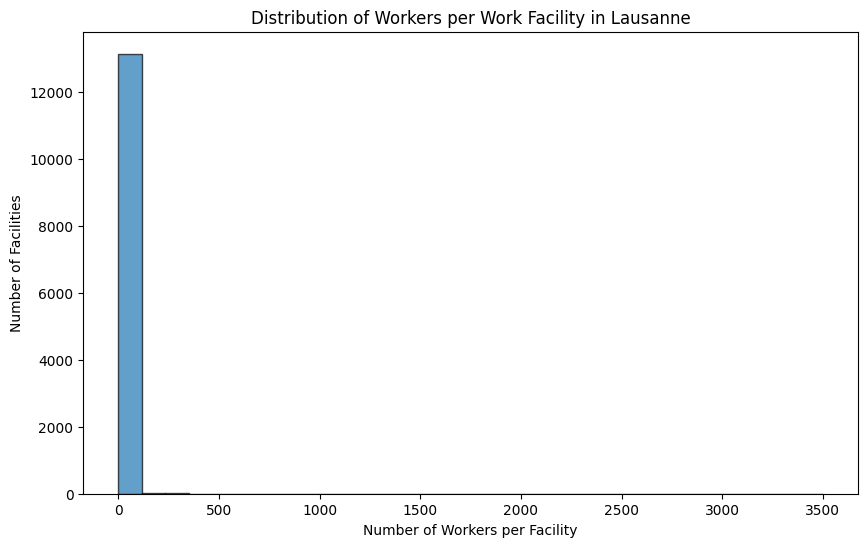

In [8]:
# work_facilities_count = work_facilities_count[:-1]
# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(work_facilities_count, bins=30, edgecolor='black', alpha=0.7)

# Ajouter des titres et des labels
plt.title(f'Distribution of Workers per Work Facility in {LOCAL}')
plt.xlabel('Number of Workers per Facility')
plt.ylabel('Number of Facilities')

# Afficher l'histogramme
plt.show()

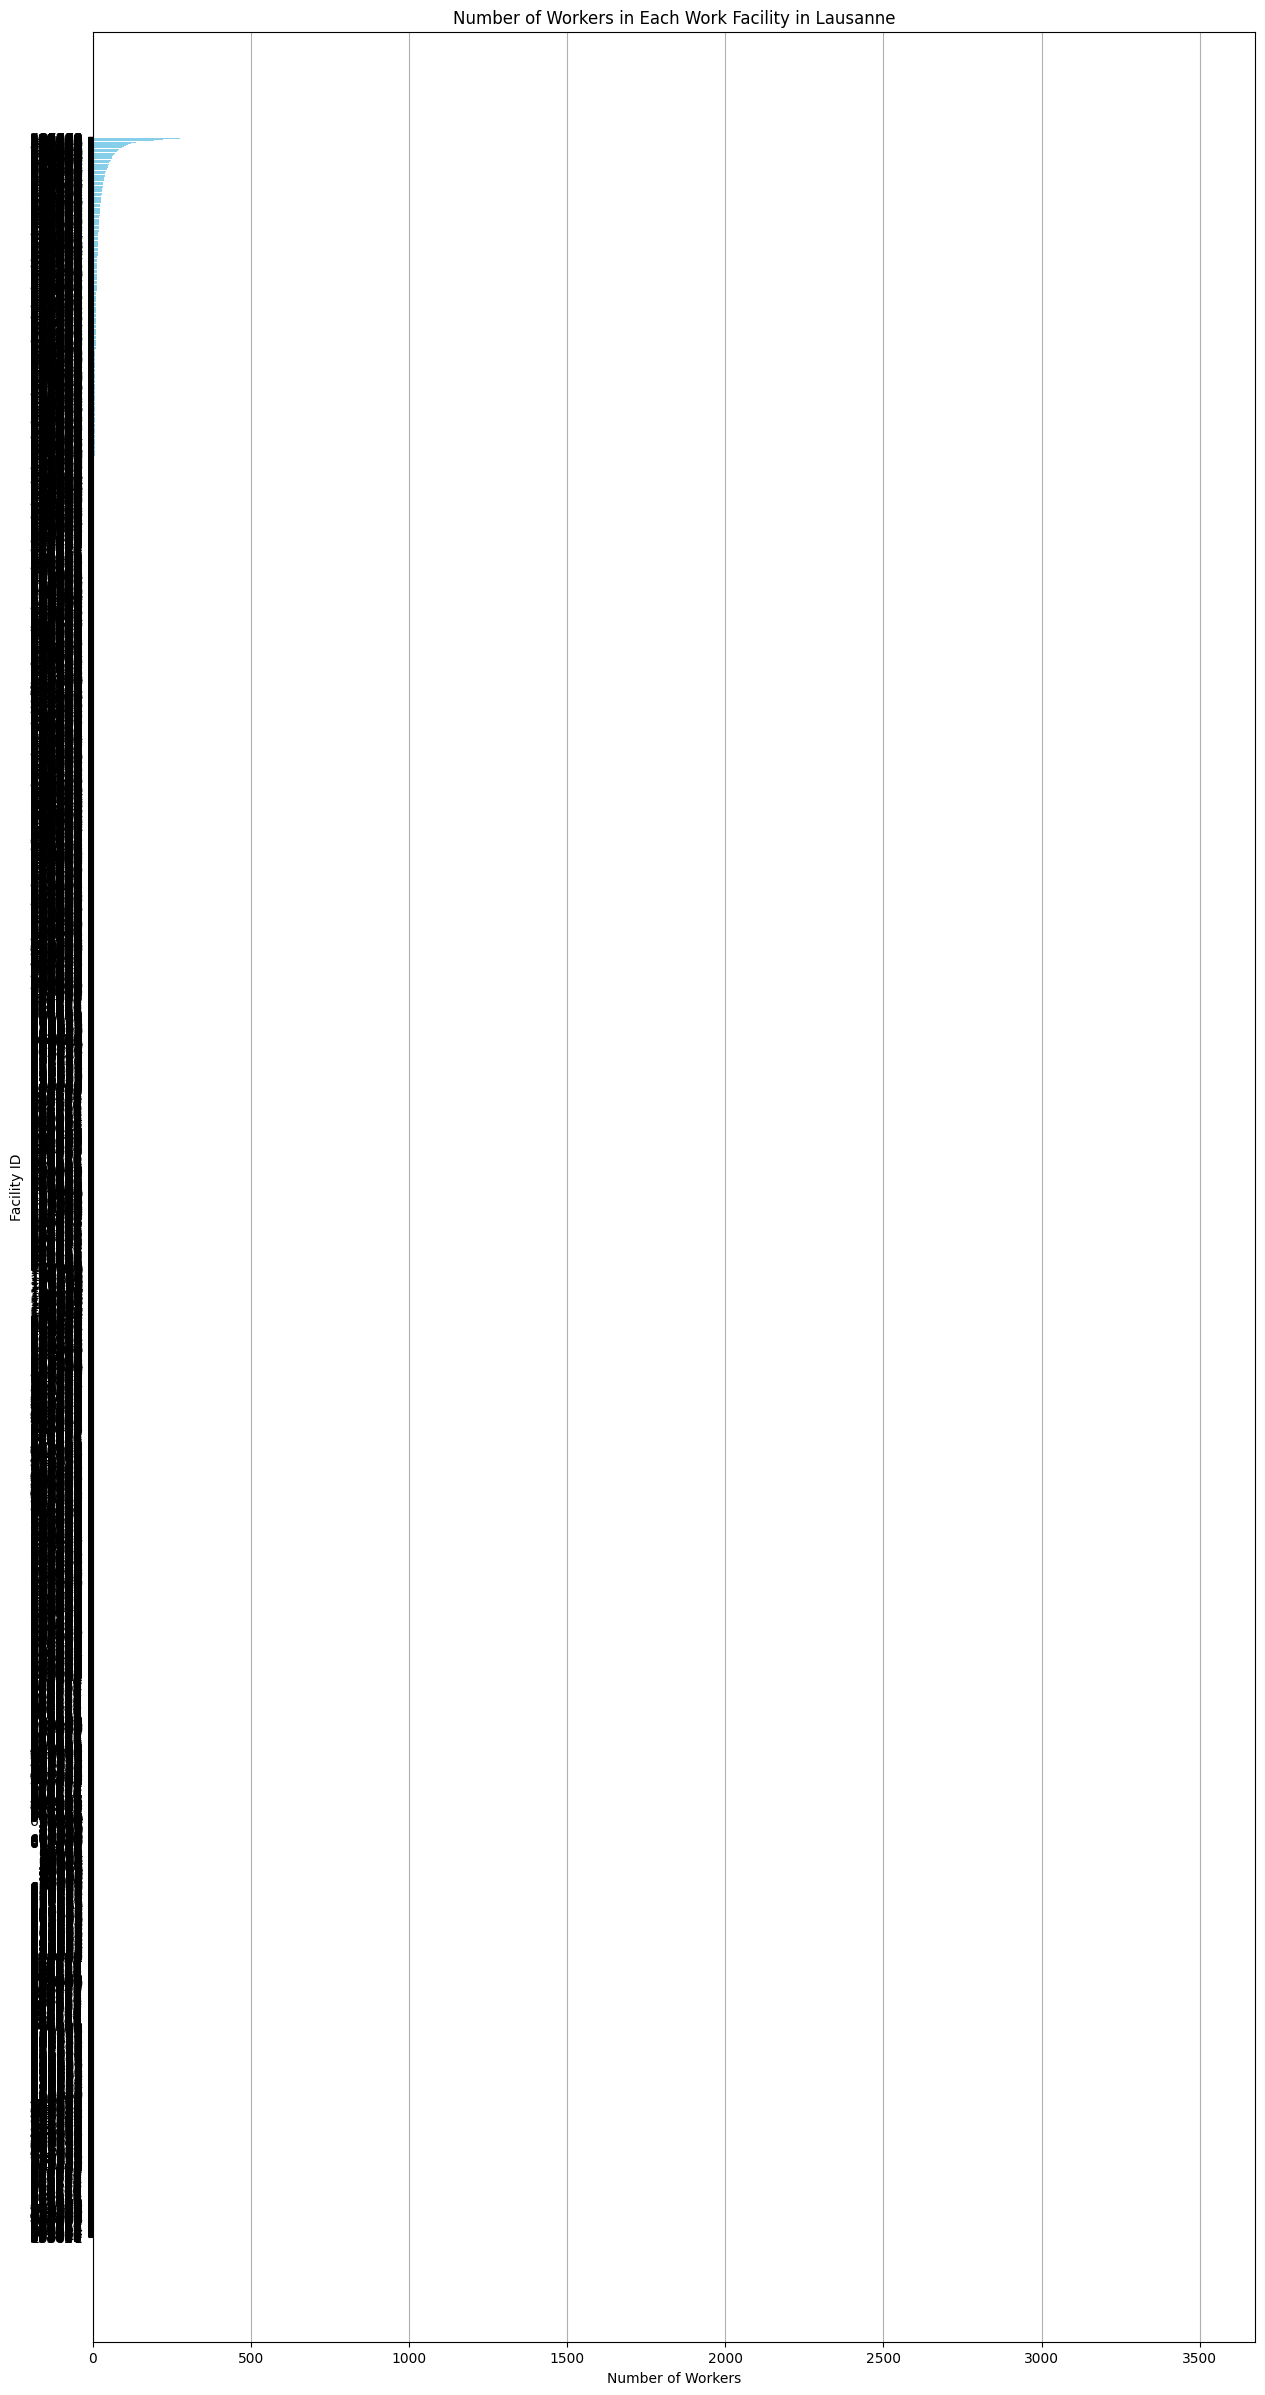

In [9]:
# Créer le diagramme à barres
plt.figure(figsize=(15, 30))  # Vous devrez peut-être ajuster la taille pour la lisibilité
plt.barh(work_facilities_count.index.astype(str), work_facilities_count.values, color='skyblue')
plt.xlabel('Number of Workers')
plt.ylabel('Facility ID')
plt.title(f'Number of Workers in Each Work Facility in {LOCAL}')
plt.grid(axis='x')

# Afficher le graphique
plt.show()

In [56]:
# Supposons que work_facilities_count est votre DataFrame avec 'facility' comme index et un comptage des travailleurs comme valeurs
facilities = work_facilities_count.index.tolist()
workers = work_facilities_count.tolist()

# Choisir un établissement aléatoirement, avec le nombre de travailleurs comme poids
chosen_facility = random.choices(facilities, weights=workers, k=1)[0]

# Trouver le nombre de travailleurs dans l'établissement choisi
num_workers_in_chosen_facility = work_facilities_count.loc[chosen_facility]

print(f"Établissement choisi : {chosen_facility}")
print(f"Nombre de travailleurs dans l'établissement choisi : {num_workers_in_chosen_facility}")

Établissement choisi : 101349
Nombre de travailleurs dans l'établissement choisi : 2


## Start / duration times distribution of each sub-population

In [10]:
pd.set_option('mode.chained_assignment', None)

# Assuming 'start_time' and 'end_time' are in a format recognized by pandas (like 'HH:MM:SS')
activity_local_filt['start_time'] = pd.to_timedelta(activity_local_filt['start_time'].astype(str))
activity_local_filt['end_time'] = pd.to_timedelta(activity_local_filt['end_time'].astype(str))

# Filter out any NaT values or times that are not within the correct range
# For example, checking that 'start_time' and 'end_time' are less than 24 hours
activity_local_filt = activity_local_filt[
    (activity_local_filt['start_time'] < pd.Timedelta('1 days')) &
    (activity_local_filt['end_time'] < pd.Timedelta('1 days'))
]

# Convert 'start_time' and 'end_time' to 'datetime.time' if they are within a single day.
activity_local_filt['start_time'] = activity_local_filt['start_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)
activity_local_filt['end_time'] = activity_local_filt['end_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)

activity_local_filt['start_time_interval'] = activity_local_filt['start_time'].apply(time_to_horizon_interval)
activity_local_filt['end_time_interval'] = activity_local_filt['end_time'].apply(time_to_horizon_interval)
activity_local_filt['duration_interval'] = activity_local_filt['end_time_interval'] - activity_local_filt['start_time_interval']

# print(len(activity_local_filt))
# activity_local_filt.head()
# population_local.head()

In [11]:
# plot age distribution 

# Get the individuals id of this 8 sub population : 
# divide population in 4 age range
# divide each of this sub-population in 2 (employed = True vs False) 

# for each sub population
    # for each activity
        # count the number of row by start_time_interval (distribution)
        # count the number of row by duration_interval (distribution)

# for each individual
    # identify its subpopulation
    # for each activity
        # pick a start_time_interval in the corresponding distribution calculated before
        # pick a duration_interval in the corresponding distribution calculated before

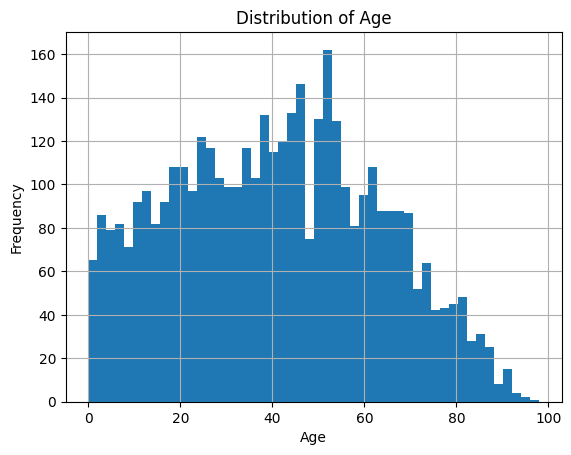

In [52]:
population_local['age'].hist(bins=50)  # Ajuster le nombre de 'bins' selon le besoin
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [13]:
# ranges = ['0-20', '21-40', '41-65', '66-100']
# Création des sous-populations
id_range1 = population_local[(population_local['age'] >= 0) & (population_local['age'] <= 18)]
id_range2_emp = population_local[(population_local['age'] >= 19) & (population_local['age'] <= 35) & (population_local['employed'] == True)]
id_range3_emp = population_local[(population_local['age'] >= 36) & (population_local['age'] <= 65) & (population_local['employed'] == True)]
id_range4_emp = population_local[(population_local['age'] >= 66) & (population_local['age'] <= 100) & (population_local['employed'] == True)]
id_range2_unemp = population_local[(population_local['age'] >= 21) & (population_local['age'] <= 40) & (population_local['employed'] == False)]
id_range3_unemp = population_local[(population_local['age'] >= 41) & (population_local['age'] <= 65) & (population_local['employed'] == False)]
id_range4_unemp = population_local[(population_local['age'] >= 66) & (population_local['age'] <= 100) & (population_local['employed'] == False)]
# id_range1.head()

In [14]:
def calculate_distributions(sub_population, activity_local_filt):
    '''Fonction pour calculer la distribution des intervalles de temps de début et de durée
    Returns a dictionary distributions['start_time_interval'] = count // distributions['duration_interval'] = count'''
    distributions = {}
    sub_population_ids = sub_population['id'].unique()
    filtered_activities = activity_local_filt[activity_local_filt['id'].isin(sub_population_ids)]

    for activity_type in filtered_activities['type'].unique():
        activity_data = filtered_activities[filtered_activities['type'] == activity_type]
        start_dist = activity_data['start_time_interval'].value_counts(normalize=True)
        duration_dist = activity_data['duration_interval'].value_counts(normalize=True)
        distributions[activity_type] = {'start': start_dist, 'duration': duration_dist}
    
    return distributions

def get_subpopulation_id(person):
    age, employed = person['age'], person['employed']
    if age <= 18:
        return 'range1'
    elif age <= 35:
        return 'range2_emp' if employed else 'range2_unemp'
    elif age <= 65:
        return 'range3_emp' if employed else 'range3_unemp'
    else:
        return 'range4_emp' if employed else 'range4_unemp'

# Calculer les distributions pour chaque sous-population
distributions = {
    'range1': calculate_distributions(id_range1, activity_local_filt),
    'range2_emp': calculate_distributions(id_range2_emp, activity_local_filt),
    'range3_emp': calculate_distributions(id_range3_emp, activity_local_filt),
    'range4_emp': calculate_distributions(id_range4_emp, activity_local_filt),
    'range2_unemp': calculate_distributions(id_range2_unemp, activity_local_filt),
    'range3_unemp': calculate_distributions(id_range3_unemp, activity_local_filt),
    'range4_unemp': calculate_distributions(id_range4_unemp, activity_local_filt),
}
# print(distributions['range4_emp'])

In [15]:
# Initialisation des colonnes pour les durées et heures de début d'activité
for activity_type in activity_types:
    population_local[f'{activity_type}_start'] = 0
    population_local[f'{activity_type}_dur'] = 0

# Pour chaque individu et activity type, choisir aléatoirement un intervalle de temps de début et de durée
for index, person in population_local.iterrows():
    subpop_id = get_subpopulation_id(person)
    for activity_type, dist in distributions[subpop_id].items():
        chosen_start = np.random.choice(dist['start'].index, p=dist['start'].values)
        chosen_duration = np.random.choice(dist['duration'].index, p=dist['duration'].values)
        if subpop_id == 'range1' and activity_type == 'work':
            chosen_start = 0
            chosen_duration = 0
        population_local.at[index, f'{activity_type}_start'] = chosen_start
        population_local.at[index, f'{activity_type}_dur'] = chosen_duration
    
# population_local.sort_values('age').head(30)
# population_local.head(40)

# Distance work / home

### Ours

In [16]:
# population_local_sample = population_vaud[population_vaud['local'] == LOCAL] 
# # Drop rows where any of the required columns have NaNs
# population_local_sample.dropna(subset=['home_x', 'home_y', 'work_x', 'work_y'], inplace=True)

# # Now apply the distance calculation
# population_local_sample['distance_H2W'] = np.sqrt(
#     (population_local_sample['home_x'] - population_local_sample['work_x'])**2 +
#     (population_local_sample['home_y'] - population_local_sample['work_y'])**2
# )
# population_local_sample['distance_H2W'].mean()

In [17]:
# import matplotlib.pyplot as plt
# # Plot the distribution of distance
# plt.figure(figsize=(10, 6))
# plt.hist(population_local_sample['distance_H2W'], bins=30, alpha=0.7, color='blue')
# plt.title('Distribution of Distance from Home to Work')
# plt.xlabel('Distance')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# # Plot the boxplot of the distance
# plt.figure(figsize=(10, 2))
# plt.boxplot(population_local_sample['distance_H2W'].dropna(), vert=False)  # Drop NA values for boxplot
# plt.title('Boxplot of Distance from Home to Work')
# plt.xlabel('Distance')
# plt.grid(True)
# plt.show()

### Real one

# Travel speed study

In [18]:
DATA_PATH = "Data/Original/"
trip_file = DATA_PATH +'vaud_trips.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

trip_df = read_gzipped_csv(trip_file)[['id', 'mode', 'trav_time', 'start_link', 'end_link']]

In [51]:
# activity_local.head(2)
# ocnvert to datetime, replace NAN, filter all garbage activities?

In [50]:
# Select only required columns from activity_local and rename them for clarity
activity_local_start = activity_local.drop_duplicates(subset=['link']).copy()
activity_local_start = activity_local_start[['link', 'x', 'y']].add_suffix('_start')

activity_local_end = activity_local.drop_duplicates(subset=['link']).copy()
activity_local_end = activity_local_end[['link', 'x', 'y']].add_suffix('_end')


trip_df_local = trip_df[trip_df['id'].isin(population_local_ids)]
trip_df_local = trip_df_local.dropna(subset= ['trav_time'], axis=0)
trip_df_local = trip_df_local.sample(frac=1)
# trip_df_local_filt = trip_df_local[trip_df_local['mode']=='walk']
trip_df_local_filt = trip_df_local
print(len(trip_df_local_filt))

5927


In [43]:
# Merge trip_df with activity_local_start
trip_detailed = trip_df_local_filt.merge(activity_local_start, how='left', left_on='start_link', right_on='link_start')
trip_detailed = trip_detailed.drop(columns=['link_start'])  # Drop the extra link column
trip_detailed = trip_detailed.dropna(subset=['x_start', 'y_start'], axis=0)

# Merge trip_detailed with activity_local_end
trip_detailed2 = trip_detailed.merge(activity_local_end, how='left', left_on='end_link', right_on='link_end')
trip_detailed2 = trip_detailed2.drop(columns=['link_end'])  # Drop the extra link column
trip_detailed2 = trip_detailed2.dropna(subset=['x_end', 'y_end'], axis=0)
trip_detailed2.sample(5)

,id,mode,trav_time,start_link,end_link,x_start,y_start,x_end,y_end
13402,7121305,car,00:10:18,82836,57603,2573684.0,1192344.0,2.569527e+06,1.192096e+06
6385,6995164,walk,00:05:38,59111,58734,2569608.0,1192200.0,2.569650e+06,1.192521e+06
2351,6682640,car,00:04:37,90828,825985,2569760.0,1191831.0,2.567860e+06,1.191760e+06
9766,6459026,walk,00:11:49,82542,648847,2605524.0,1211329.0,2.605255e+06,1.210733e+06
12074,6682640,car,00:03:20,825985,103701,2567860.0,1191760.0,2.567524e+06,1.190670e+06


In [44]:
trip_detailed2['distance'] = np.sqrt(
    (trip_detailed2['x_start'] - trip_detailed2['x_end'])**2 +
    (trip_detailed2['y_start'] - trip_detailed2['y_end'])**2
) / 1000

# Convert trav_time to timedelta if it's not already
trip_detailed2['trav_time'] = pd.to_timedelta(trip_detailed2['trav_time'])


# Print the total number of rows in the DataFrame
print("Total number of rows:", len(trip_detailed2))

# Check for rows with zero or near-zero travel time
# Adjust the condition if necessary (e.g., check for extremely small values if needed)
zero_travel_time = trip_detailed2['trav_time'].dt.total_seconds() <= 10
print("Number of rows with zero or near-zero travel time:", zero_travel_time.sum())

# Set speed to NaN where travel time is zero or near-zero
trip_detailed2.loc[zero_travel_time, 'speed'] = np.nan

# Recalculate speed for non-zero travel times
valid_travel_time = trip_detailed2['trav_time'].dt.total_seconds() > 0
trip_detailed2.loc[valid_travel_time, 'speed'] = trip_detailed2.loc[valid_travel_time, 'distance'] / (trip_detailed2.loc[valid_travel_time, 'trav_time'].dt.total_seconds() / 3600)

# Check the mean speed again
print("Mean speed:", trip_detailed2['speed'].mean())



Total number of rows: 16099
Number of rows with zero or near-zero travel time: 1539
Mean speed: 18.94805721933458
